# Homework 1 (Due Sep 23, 2025 by Noon) 


## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

You've learned how to create L- and M- estimators and use them to estimate the parameters of a model. Generally, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$
You can use one of the estimators we discussed in the lecture, but you should be aware that the dataset can have outliers. 


Once you write down the $\ln L$ in terms of the model parameters, $a$ and $b$, this is the expression that you now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements your favorite robust loss function, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [3]:
#write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$

def squared_loss(params, x, y, dy):
    a, b = params #yi = axi + b +ri
    model = a*x + b
    resids = y - model
    chi2 = np.sum((resids/dy)**2)
    return chi2

In [4]:
#Fit a line to the full sample by evaluating this likelihood on a grid of a, b
a_grid = np.linspace(0, 100, 100)
b_grid = np.linspace(0, 500, 100)
grid = np.zeros((len(a_grid), len(b_grid)))
for i, a in enumerate(a_grid):
    for j, b in enumerate(b_grid):
        grid[i, j] = squared_loss((a, b), x, y, dy) #grid of values
idx = np.unravel_index(np.argmin(grid), grid.shape) #find index of min in grid
a = a_grid[idx[0]] #find corresponding a value
b = b_grid[idx[1]] #find corresponding b value
print(a, b)

1.0101010101010102 227.27272727272725


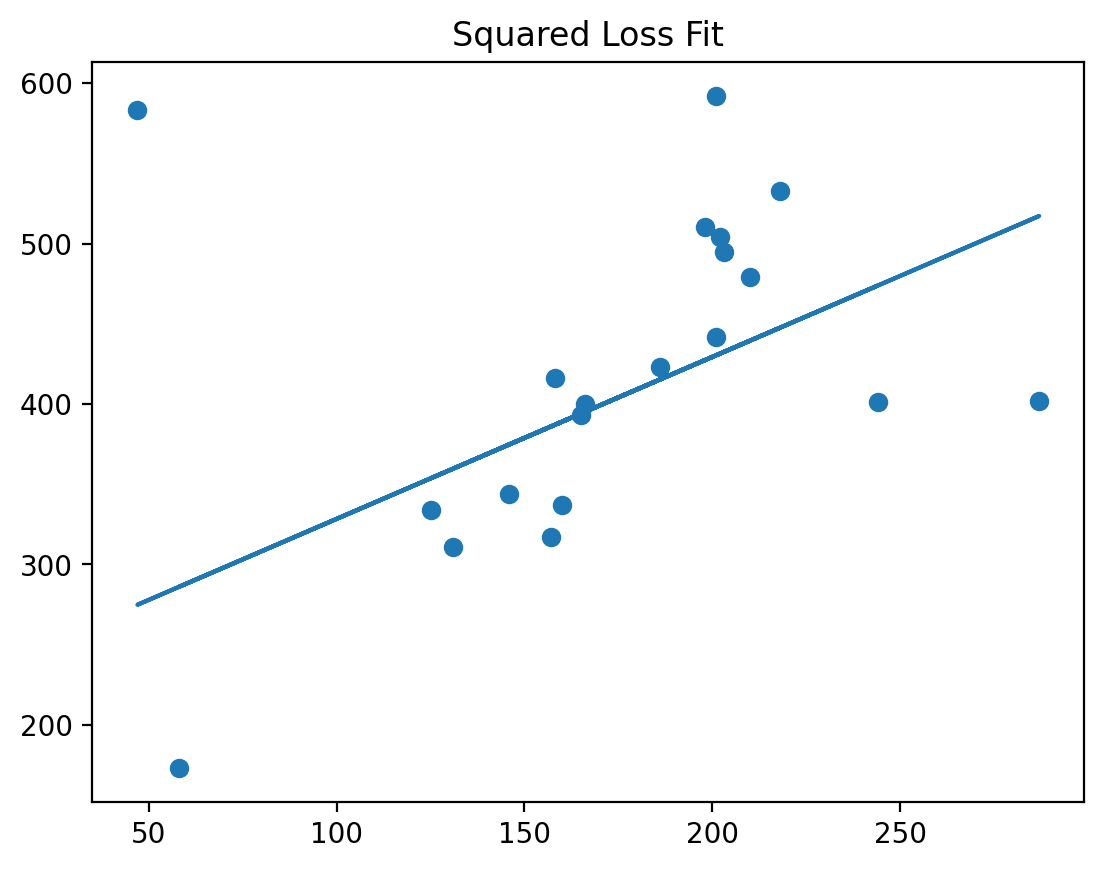

In [12]:
#plot best fit line to make sure it looks right
plt.scatter(x, y)
plt.plot(x, a*x +b)
plt.title('Squared Loss Fit')
plt.show()

2.0202020202020203 65.65656565656565


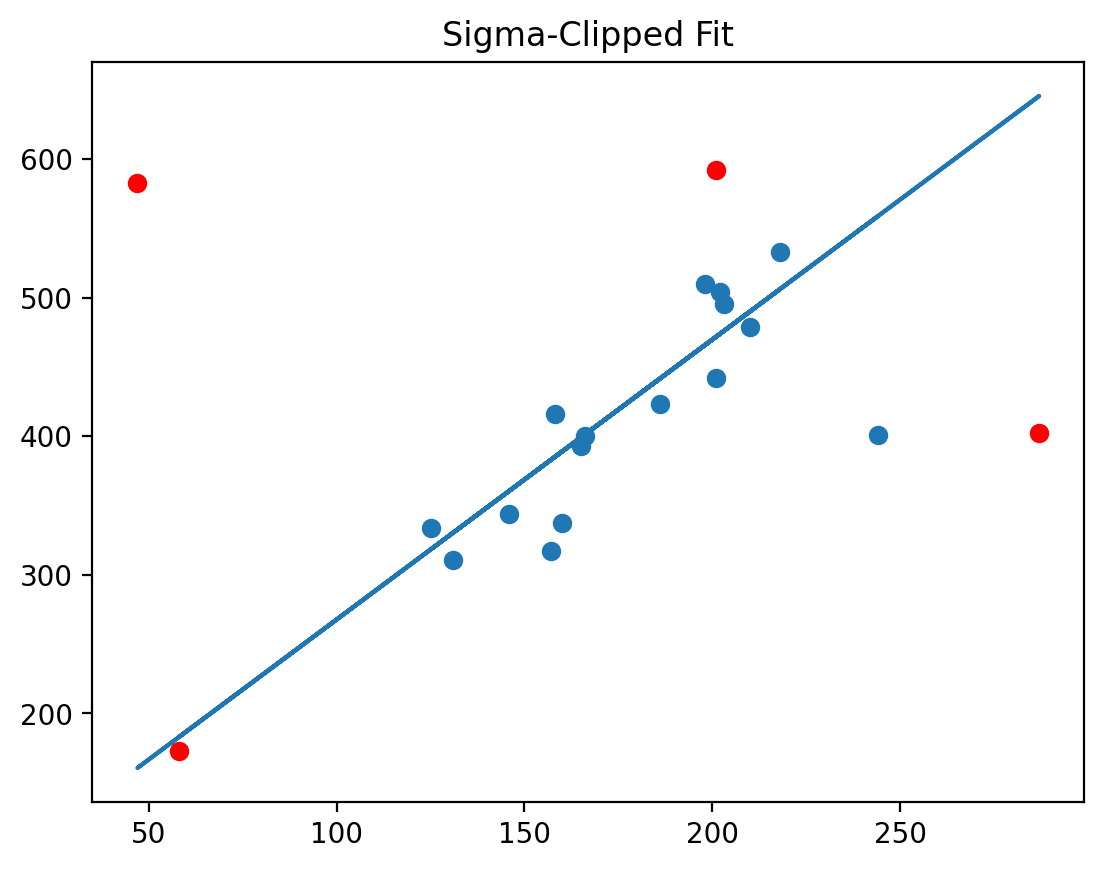

In [13]:
#Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
#sigma clipping similar to thursday lecture
resids = y - (a * x + b)
sigma_clip = np.abs(resids) < 1.0 * np.std(resids) #1sig seems reasonable, similar to thursday lecture

grid_clip = np.zeros((len(a_grid), len(b_grid))) #redo with outliers rejected
for i, a_clip in enumerate(a_grid): 
    for j, b_clip in enumerate(b_grid):
        grid_clip[i, j] = squared_loss((a_clip, b_clip), x[sigma_clip], y[sigma_clip], dy[sigma_clip]) #grid of values
idx_clip = np.unravel_index(np.argmin(grid_clip), grid_clip.shape) #find index of min in grid
a_clip = a_grid[idx_clip[0]] #find corresponding a value
b_clip = b_grid[idx_clip[1]] #find corresponding b value

print(a_clip, b_clip)
plt.scatter(x[sigma_clip], y[sigma_clip])
plt.scatter(x[~sigma_clip], y[~sigma_clip], color = 'red')
plt.plot(x, a_clip*x +b_clip)
plt.title('Sigma-Clipped Fit')
plt.show()


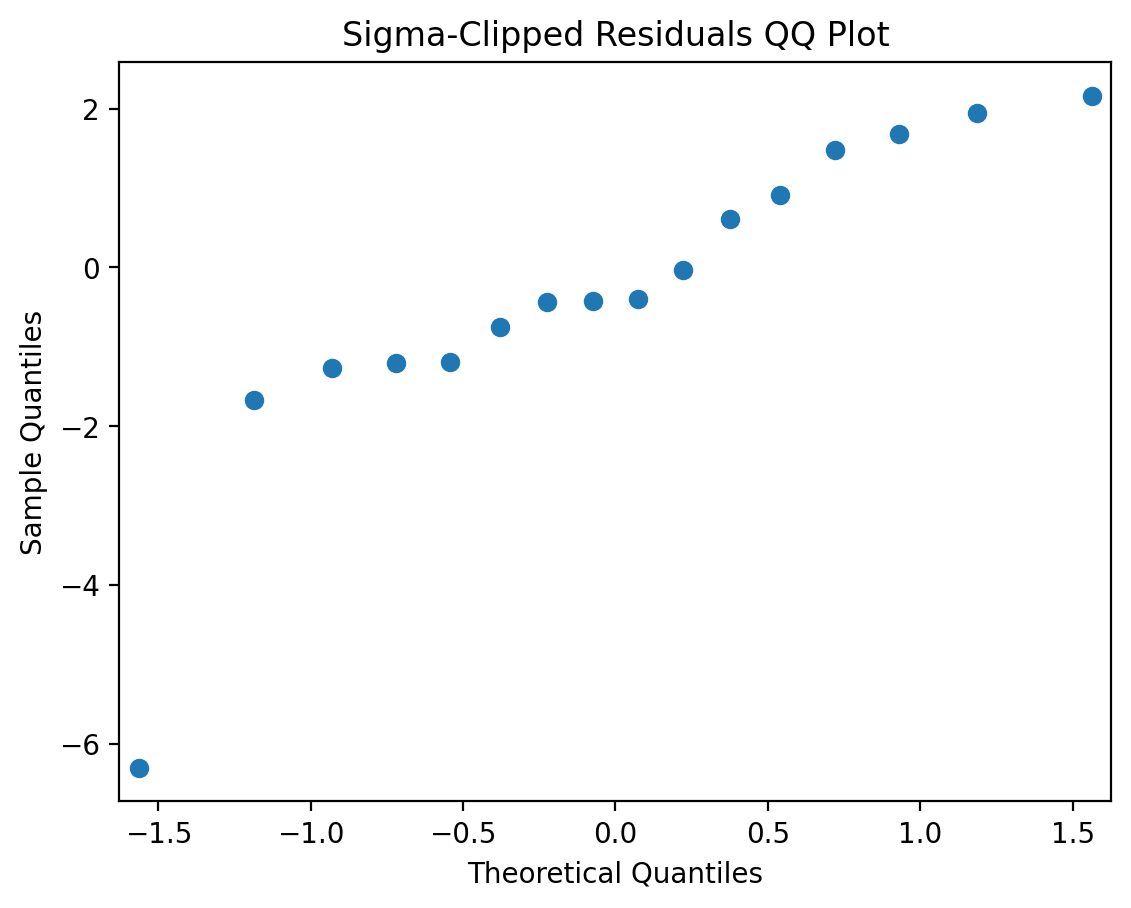

In [25]:
#make qq plot
resids_clip = (y[sigma_clip] - (a_clip * x[sigma_clip] + b_clip)) / dy[sigma_clip]
sm.qqplot(resids_clip)
plt.title('Sigma-Clipped Residuals QQ Plot')
plt.show()

In [8]:
def log_likelihood(params, x, y, dy): #doing cauchy method (gamma = 1)
    a, b = params #yi = axi + b +ri
    model = a*x + b
    resids = (y - model)/dy
    log_like = -np.sum(np.log(np.pi) + np.log(1 + (resids)**2))
    return log_like

def neg_log_likelihood(params, x, y, dy): #same as lecture notes
    return -log_likelihood(params, x, y, dy)


In [9]:
from scipy.optimize import fmin #from lecture notebook, just with new function
initial_guess = [1.0, 200.0]
result =fmin(
        neg_log_likelihood,
        initial_guess,
        args=(x, y, dy),
        maxiter = 10000, disp = True
    )
a_robust, b_robust = result
print(result)

Optimization terminated successfully.
         Current function value: 49.778660
         Iterations: 57
         Function evaluations: 109
[ 2.19937576 40.46119795]


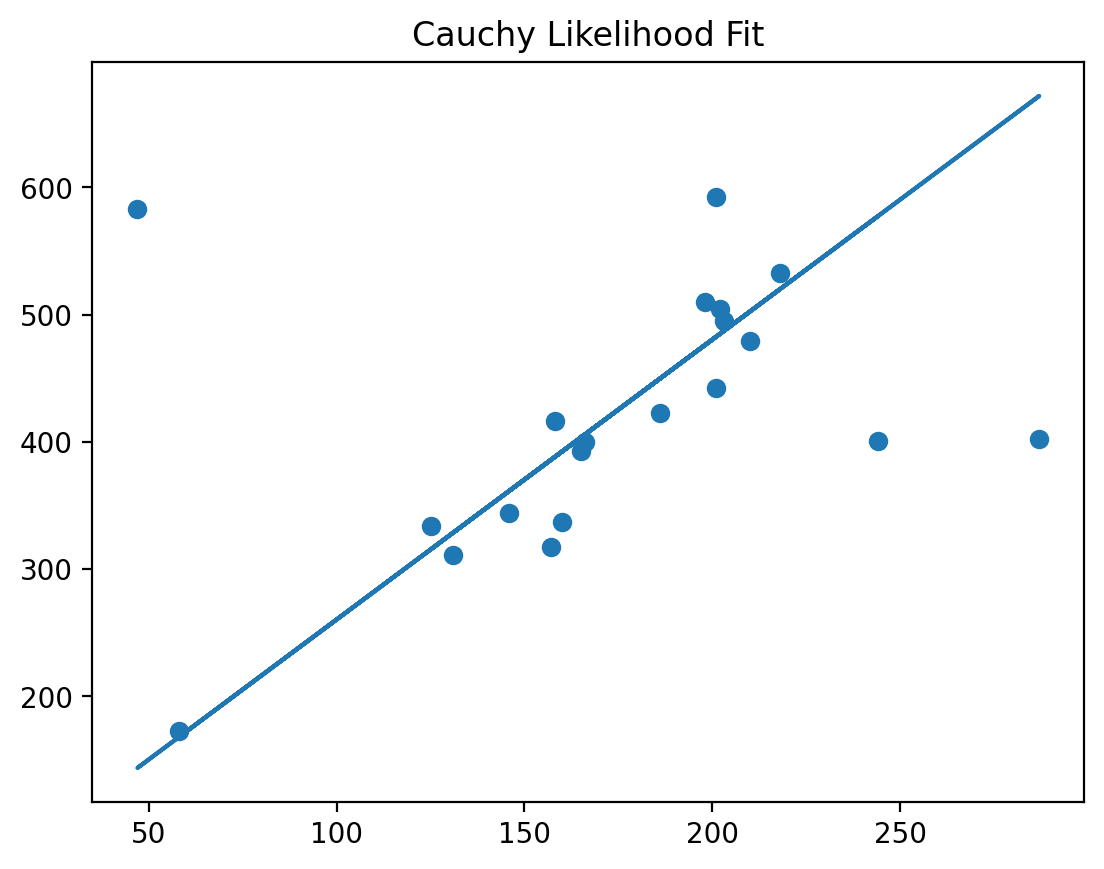

In [14]:
#plot best fit line to make sure it looks right
plt.scatter(x, y)
plt.plot(x, a_robust*x +b_robust)
plt.title('Cauchy Likelihood Fit')
plt.show()

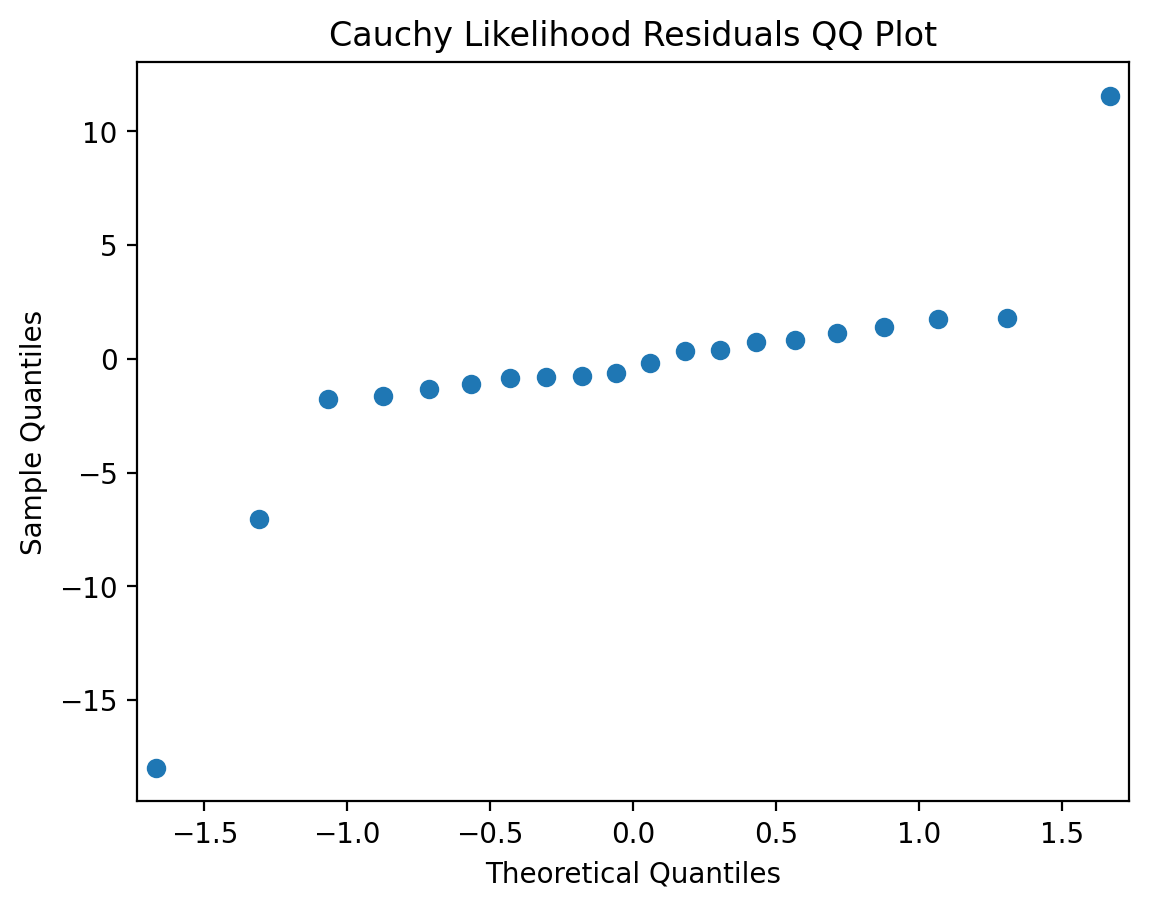

In [24]:
#make qq plot
resids_robust = (y - (a_robust * x + b_robust)) / dy
sm.qqplot(resids_robust)
plt.title('Cauchy Likelihood Residuals QQ Plot')
plt.show()

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

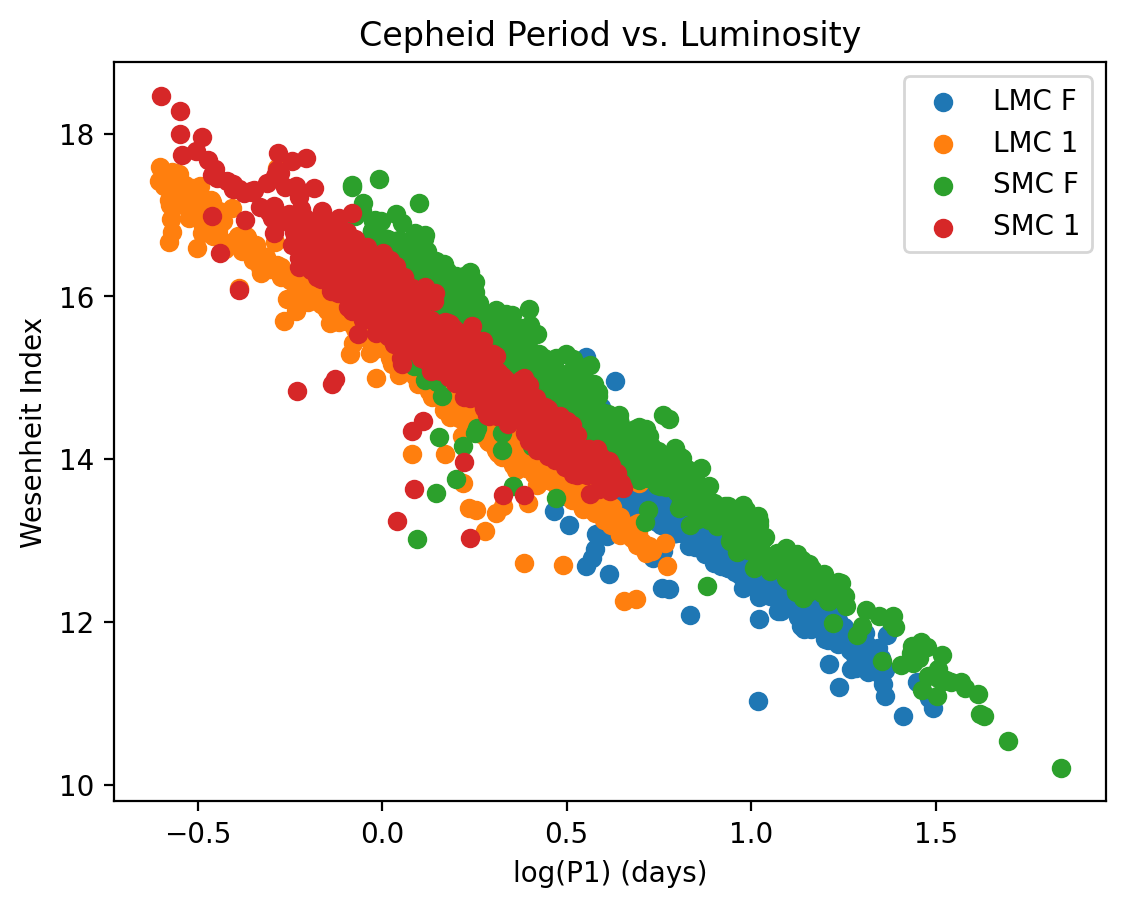

In [73]:
import pandas as pd
#Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
cepheids = pd.read_csv('Cepheids.csv')
LMC_F = cepheids[(cepheids['Cloud'] == 'LMC') & (cepheids['Mode'] == 'F')]
LMC_1 = cepheids[(cepheids['Cloud'] == 'LMC') & (cepheids['Mode'] == '1')]
SMC_F = cepheids[(cepheids['Cloud'] == 'SMC') & (cepheids['Mode'] == 'F')]
SMC_1 = cepheids[(cepheids['Cloud'] == 'SMC') & (cepheids['Mode'] == '1')]

plt.scatter(LMC_F['logP1'], LMC_F['W'], label = 'LMC F')
plt.scatter(LMC_1['logP1'], LMC_1['W'], label = 'LMC 1')
plt.scatter(SMC_F['logP1'], SMC_F['W'], label = 'SMC F')
plt.scatter(SMC_1['logP1'], SMC_1['W'], label = 'SMC 1')
plt.title('Cepheid Period vs. Luminosity')
plt.xlabel('log(P1) (days)')
plt.ylabel('Wesenheit Index')
plt.legend()
plt.show()

In [74]:
#Fit or estimate straight lines to each of the four samples using your solution to Problem 1.
a_vals = []
b_vals =  []
datasets = [LMC_F, LMC_1, SMC_F, SMC_1]
a_grid = np.linspace(-10, 0, 100)
b_grid = np.linspace(10, 20, 100)
grid = np.zeros((len(a_grid), len(b_grid)))
for dataset in datasets:
    x = dataset['logP1']
    y = dataset['W']
    dy = np.ones_like(y)
    grid = np.zeros((len(a_grid), len(b_grid)))

    for i, a in enumerate(a_grid):
        for j, b in enumerate(b_grid):
            grid[i, j] = squared_loss((a, b), x, y, dy) #grid of values
    idx = np.unravel_index(np.argmin(grid), grid.shape) #find index of min in grid
    a = a_grid[idx[0]] #find corresponding a value
    b = b_grid[idx[1]] #find corresponding b value
    a_vals.append(float(a))
    b_vals.append(float(b))
print(a_vals, b_vals)

[-3.4343434343434343, -3.333333333333333, -3.4343434343434343, -3.6363636363636367] [15.959595959595958, 15.353535353535353, 16.464646464646464, 15.959595959595958]


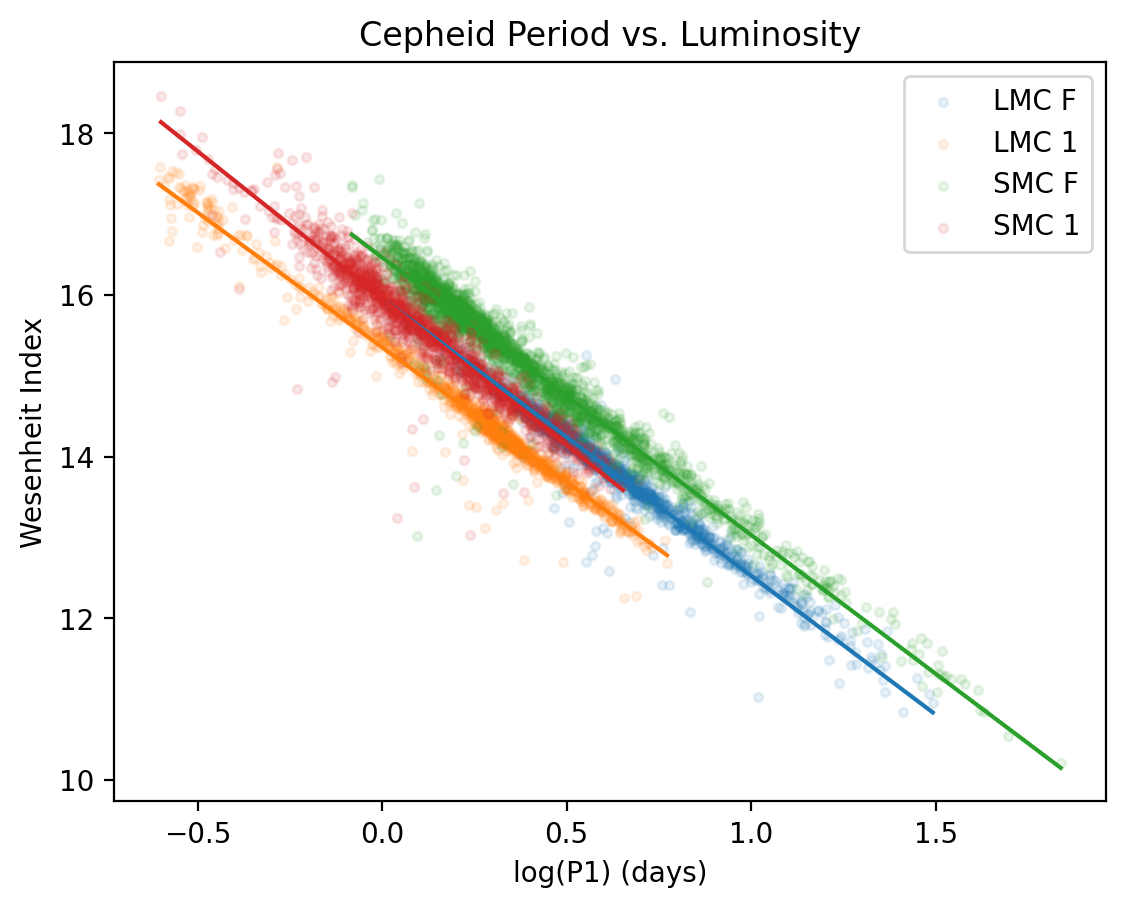

In [77]:
#plot best fit lines
plt.scatter(LMC_F['logP1'], LMC_F['W'], label = 'LMC F', alpha = 0.1, s = 10)
plt.scatter(LMC_1['logP1'], LMC_1['W'], label = 'LMC 1', alpha = 0.1, s = 10)
plt.scatter(SMC_F['logP1'], SMC_F['W'], label = 'SMC F', alpha = 0.1, s =10)
plt.scatter(SMC_1['logP1'], SMC_1['W'], label = 'SMC 1', alpha = 0.1, s = 10)
for i, dataset in enumerate(datasets):
    x_range = np.linspace(dataset['logP1'].min(), dataset['logP1'].max(), 100)
    plt.plot(x_range, a_vals[i]*x_range +b_vals[i])
plt.title('Cepheid Period vs. Luminosity')
plt.xlabel('log(P1) (days)')
plt.ylabel('Wesenheit Index')
plt.legend()
plt.show()

In [ ]:
residuals = []

for i, dataset in enumerate(datasets):
    x = dataset['logP1']
    y = dataset['W']
    model = a_vals[i] * x + b_vals[i]
    resids = y - model
    residuals.append(resids)


5637    0.193894
5638    0.056308
5639    0.301761
5640    0.312586
5641   -0.001983
          ...   
7264    0.498239
7265   -0.291405
7266   -0.350565
7267   -0.069343
7268   -1.020796
Length: 1632, dtype: float64


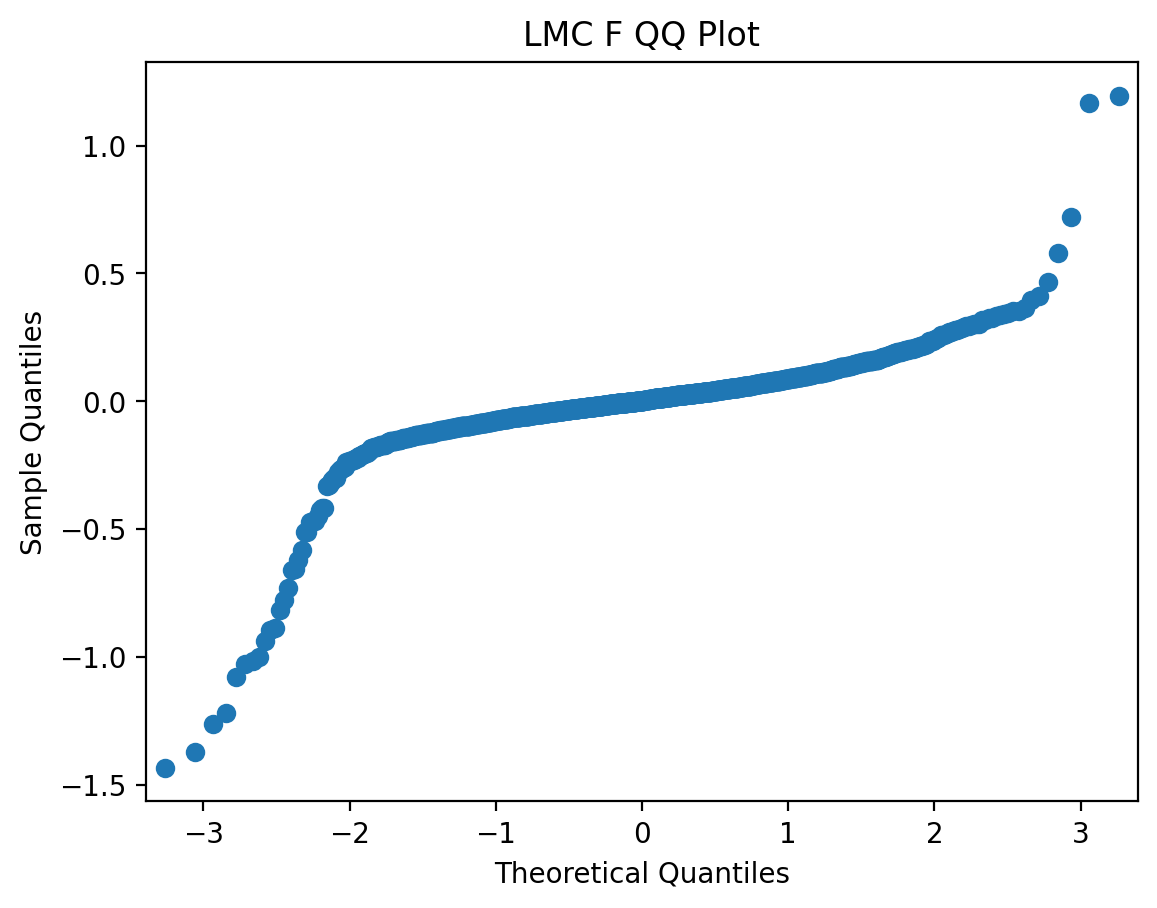

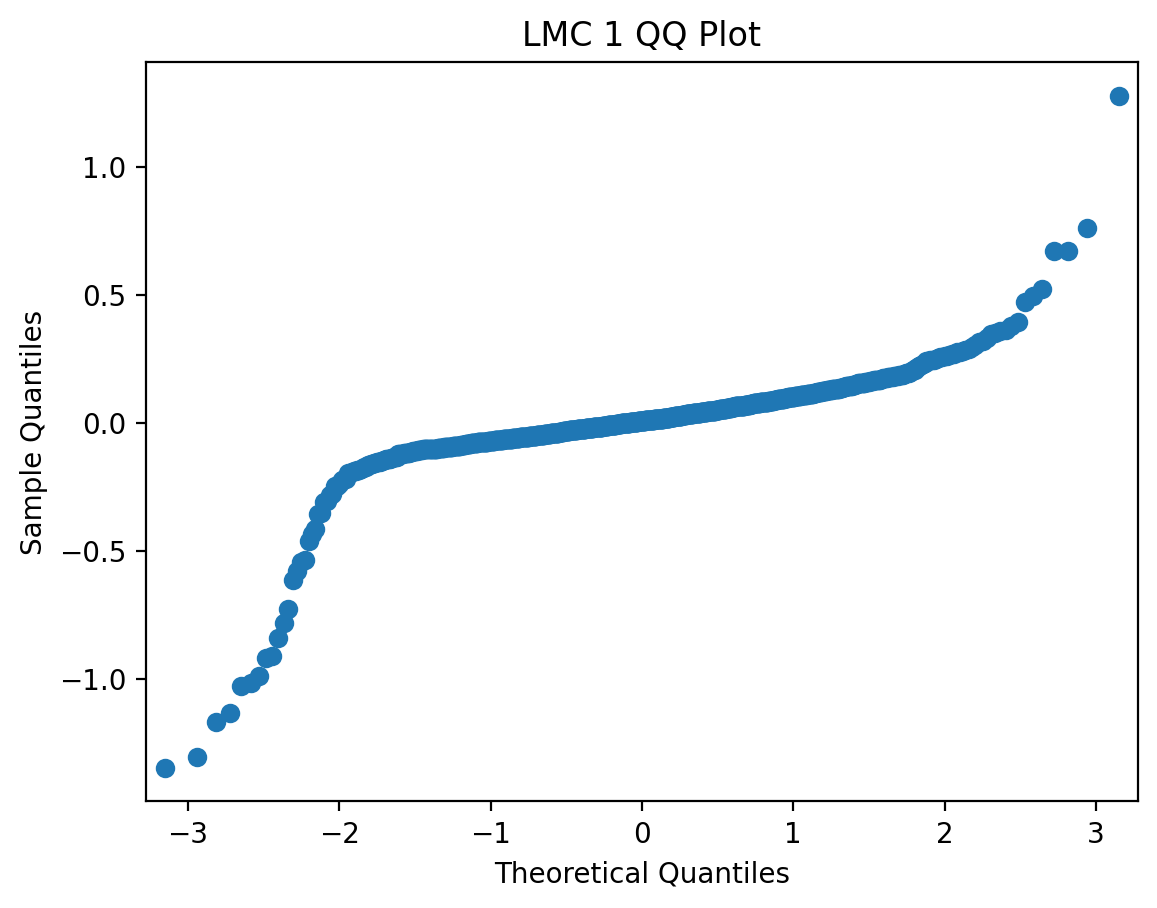

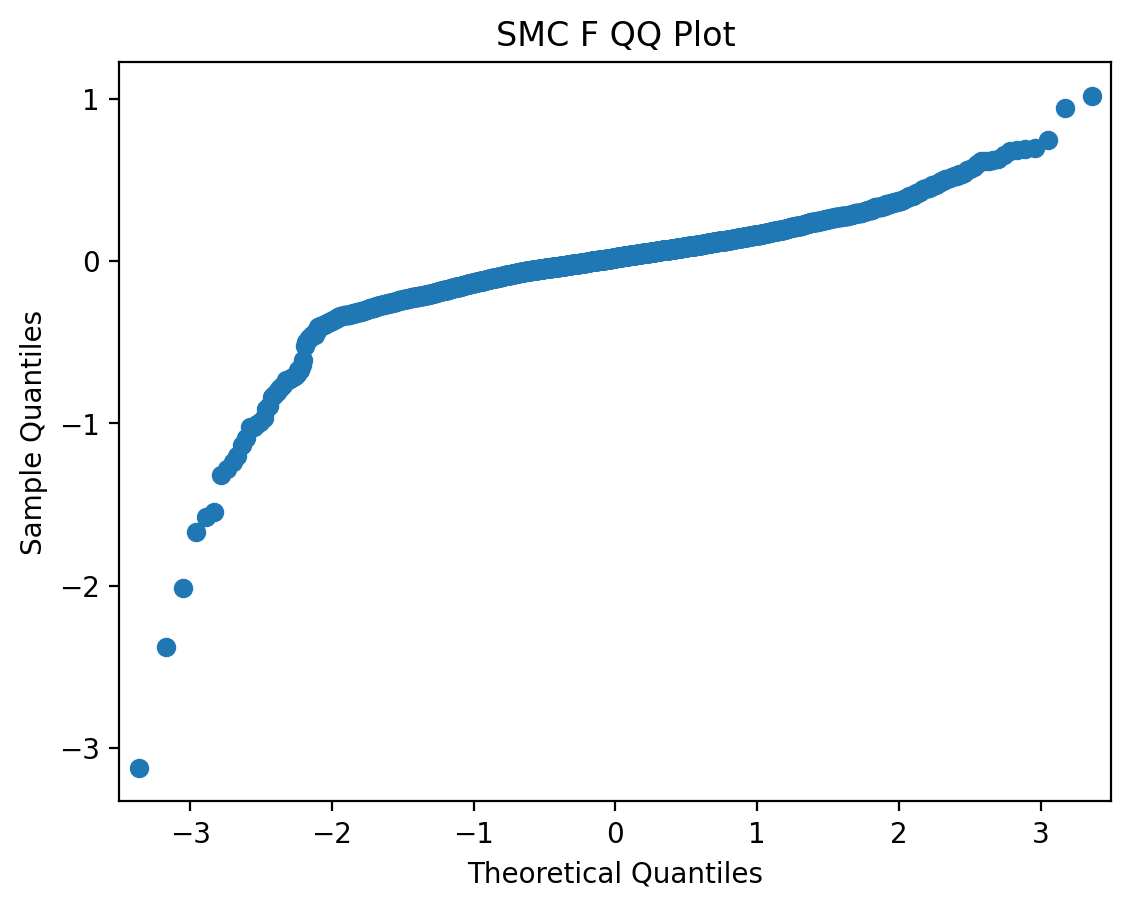

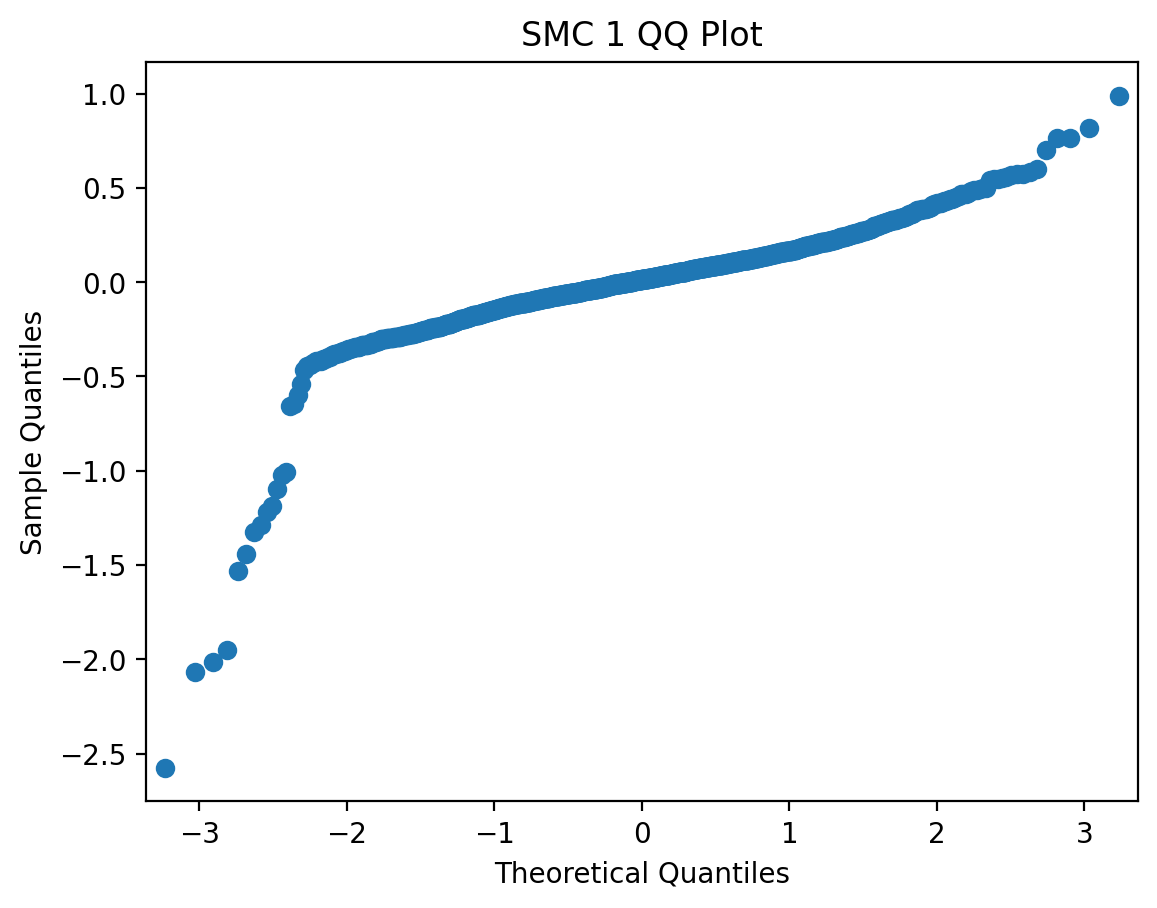

In [90]:
dataset_labels = ["LMC F", "LMC 1", "SMC F", "SMC 1"]
for i, dataset in enumerate(datasets):
    sm.qqplot(residuals[i])
    plt.title(f'{dataset_labels[i]} QQ Plot')
    plt.show()

These residuals are not normally distributed. I speculate there a few possible reasons for this. First, Cepheids are variable stars. The Wesenheit index uses their mean magnitude, but there is still scatter because you cannot measure all the Cepheids at exactly the same phase in their light curves. The period-luminosity trend itself, as discovered by Leavitt, has clear deviations (although the overall trend is certainly still clear). This is because real star observations are at all different stages of evolution, have different metallicities, etc

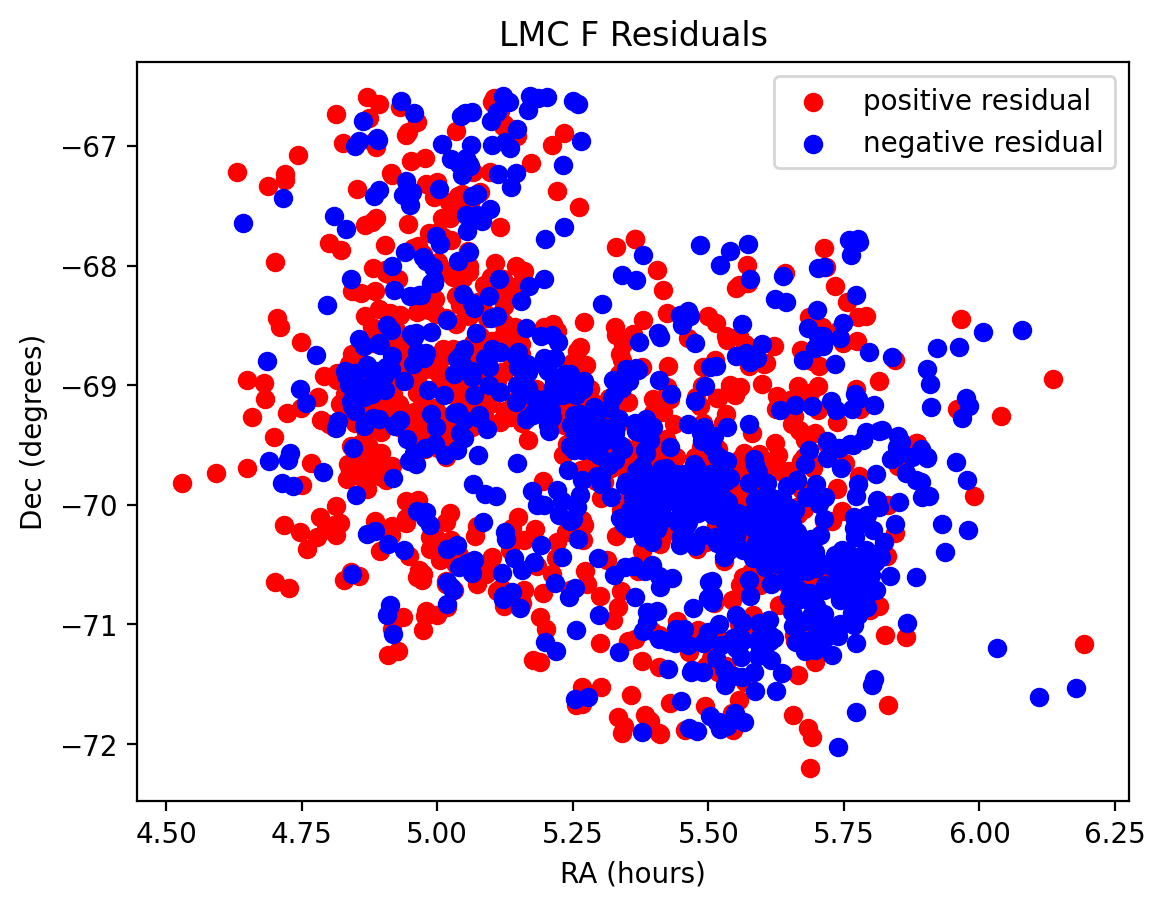

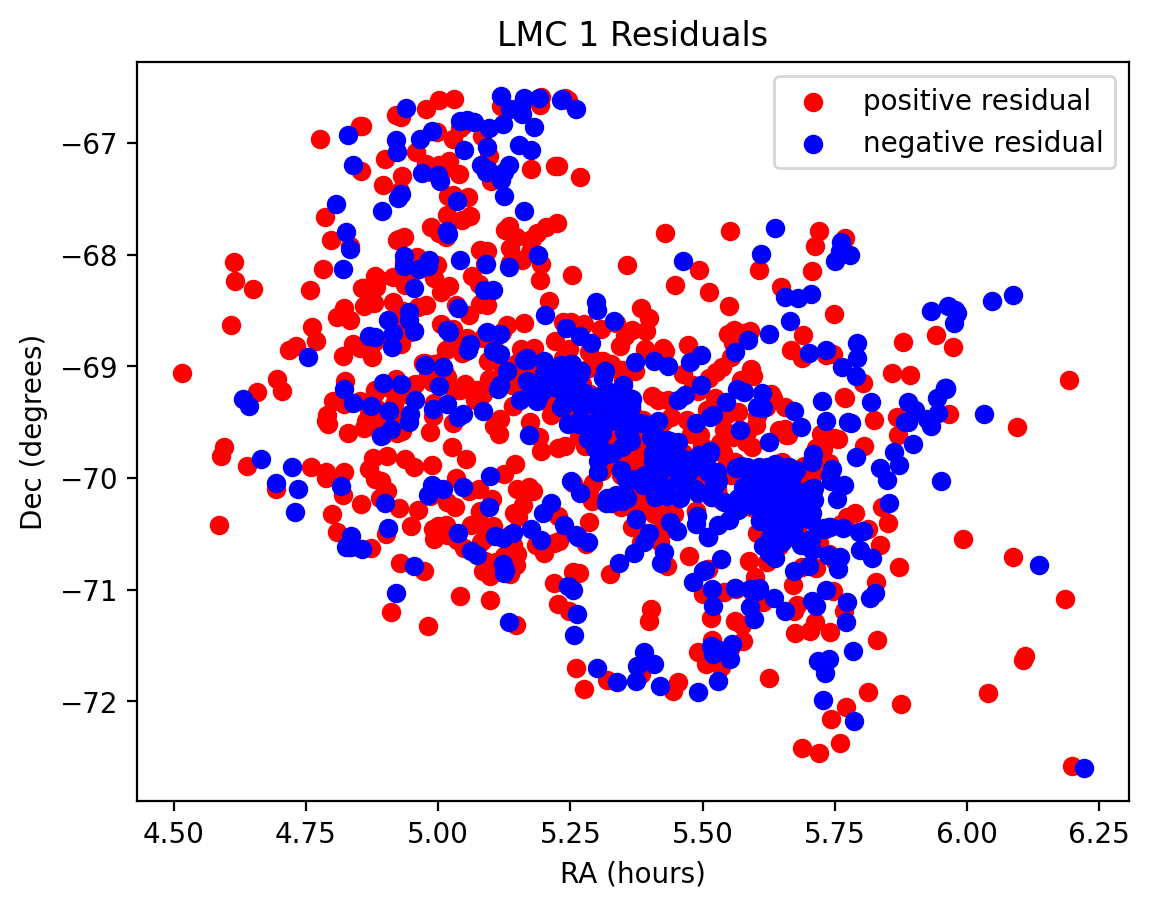

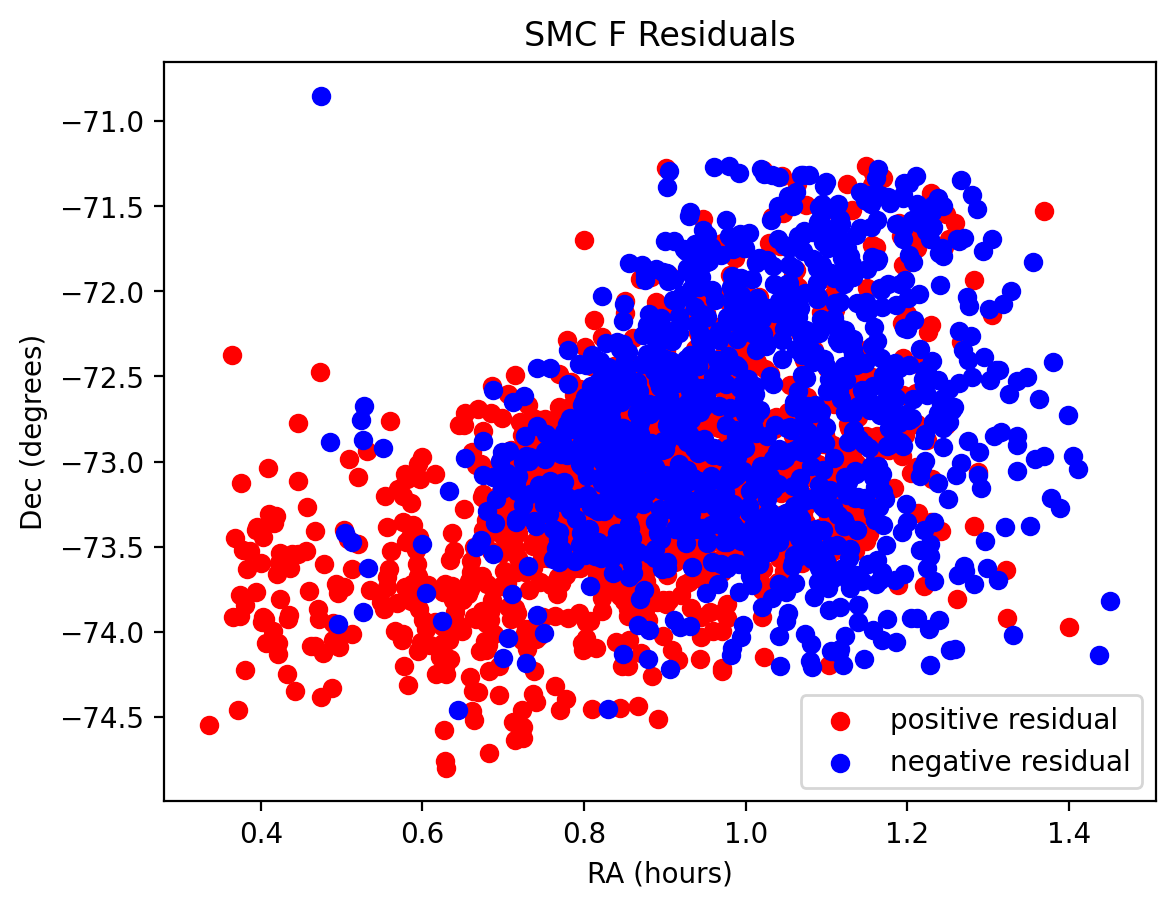

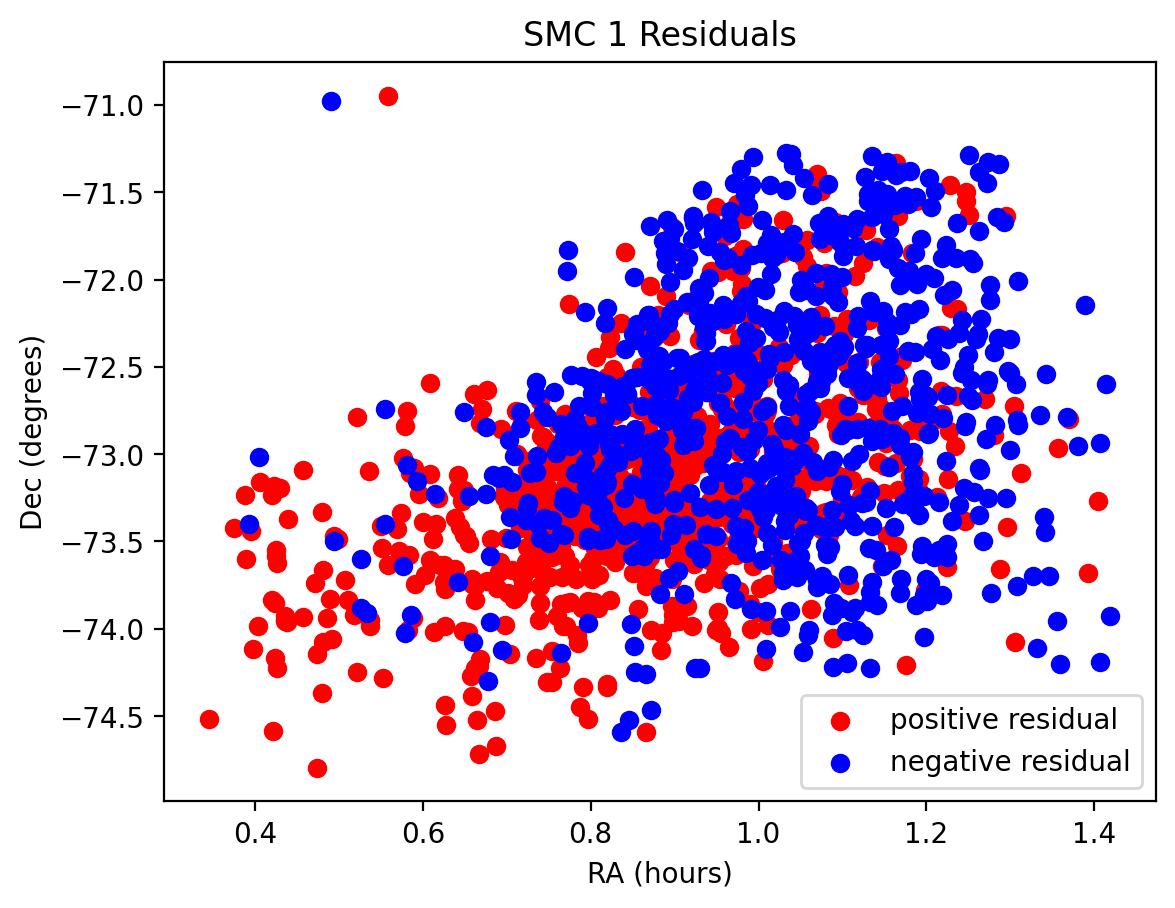

In [93]:
for i, dataset in enumerate(datasets):
    ra = dataset['RA0']
    dec = dataset['Decl0']
    resids = residuals[i]
    pos = resids > 0
    neg = resids < 0

    plt.scatter(ra[pos], dec[pos], color = 'red', label = 'positive residual') 
    plt.scatter(ra[neg], dec[neg], color = 'blue', label = 'negative residual') 
    plt.xlabel("RA (hours)")
    plt.ylabel("Dec (degrees)")
    plt.title(f"{dataset_labels[i]} Residuals")
    plt.legend()
    plt.show()

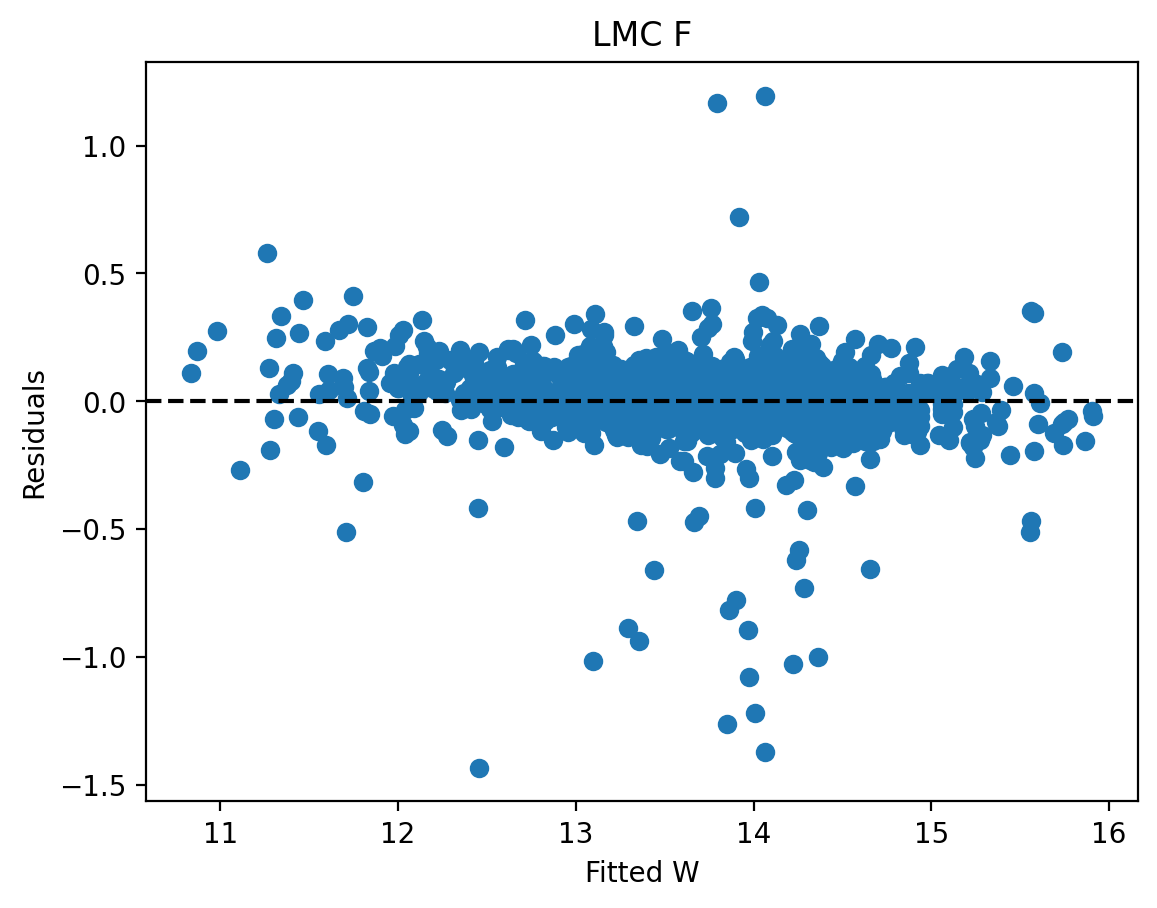

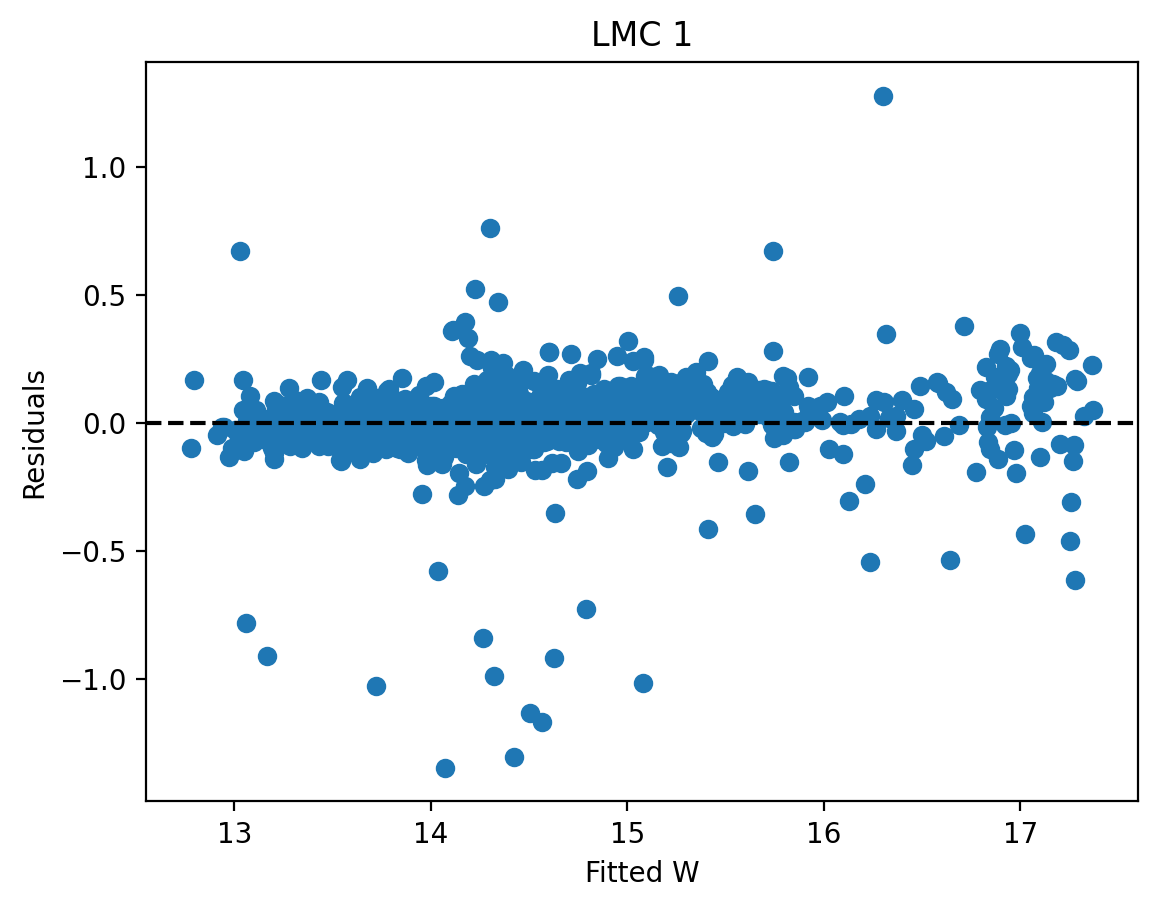

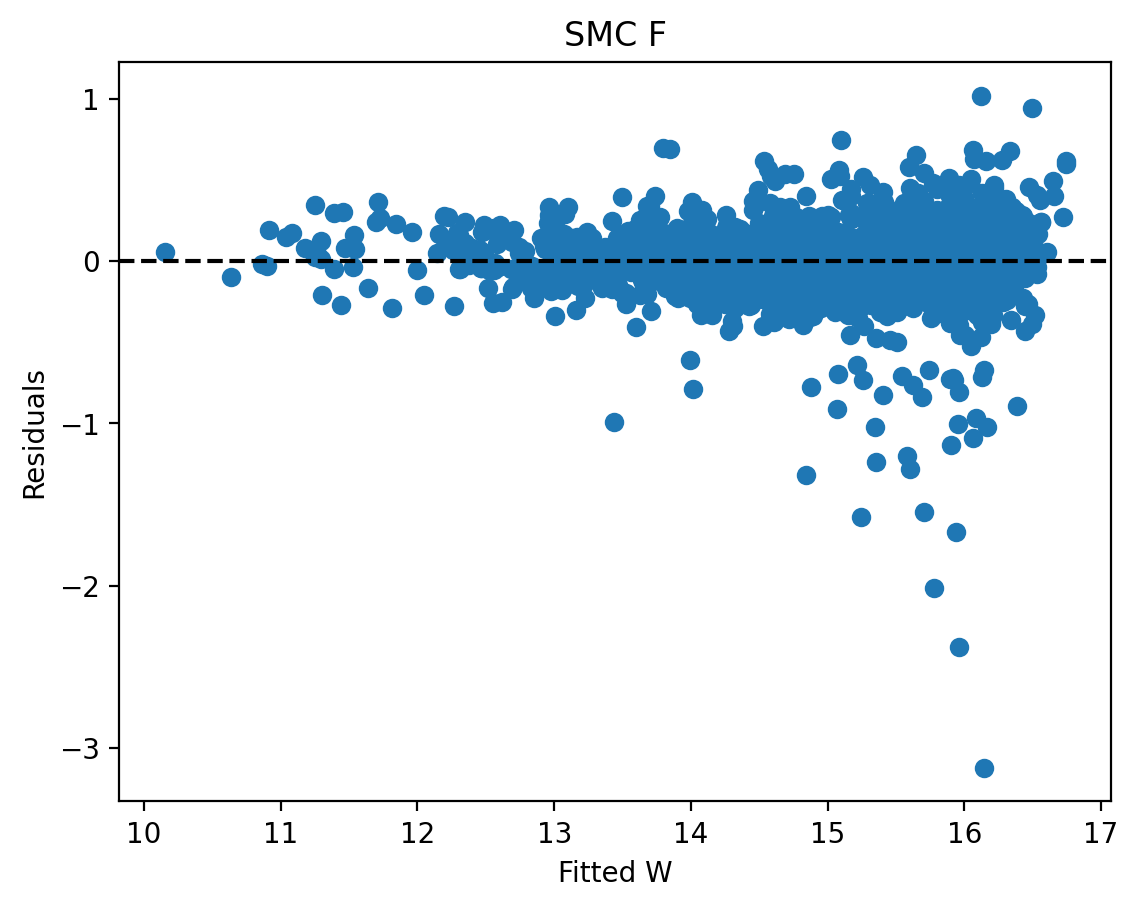

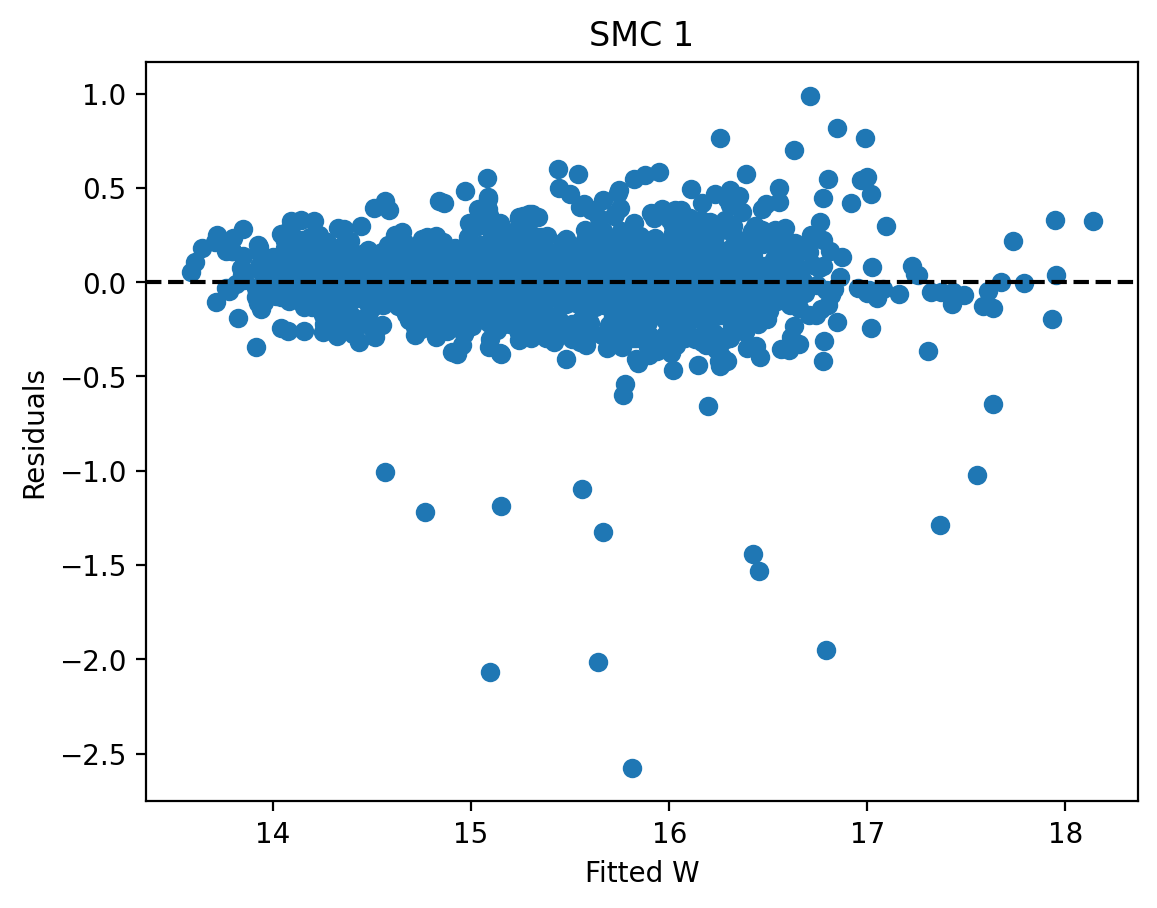

In [104]:
#plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot log(P1) vs V-I
for i, dataset in enumerate(datasets):
    x = dataset['logP1']
    model = a_vals[i] * x + b_vals[i]
    plt.scatter(model, residuals[i])
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Fitted W")
    plt.ylabel("Residuals")
    plt.title(f"{dataset_labels[i]}")
    plt.show()

The fitted W residual values are all pretty evenly clustered around 0, but a few points of large negative residuals stick out on each of the graphs. The line appears to be a good fit.


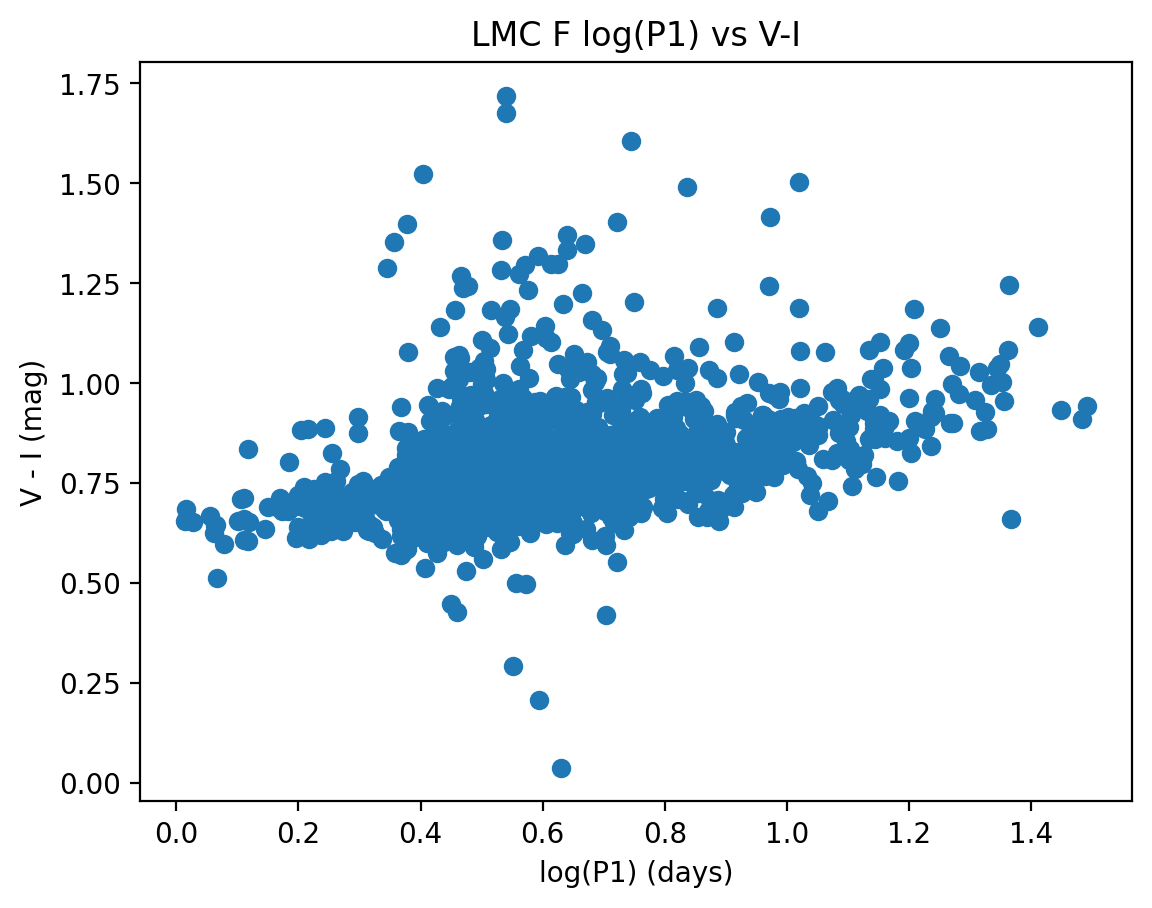

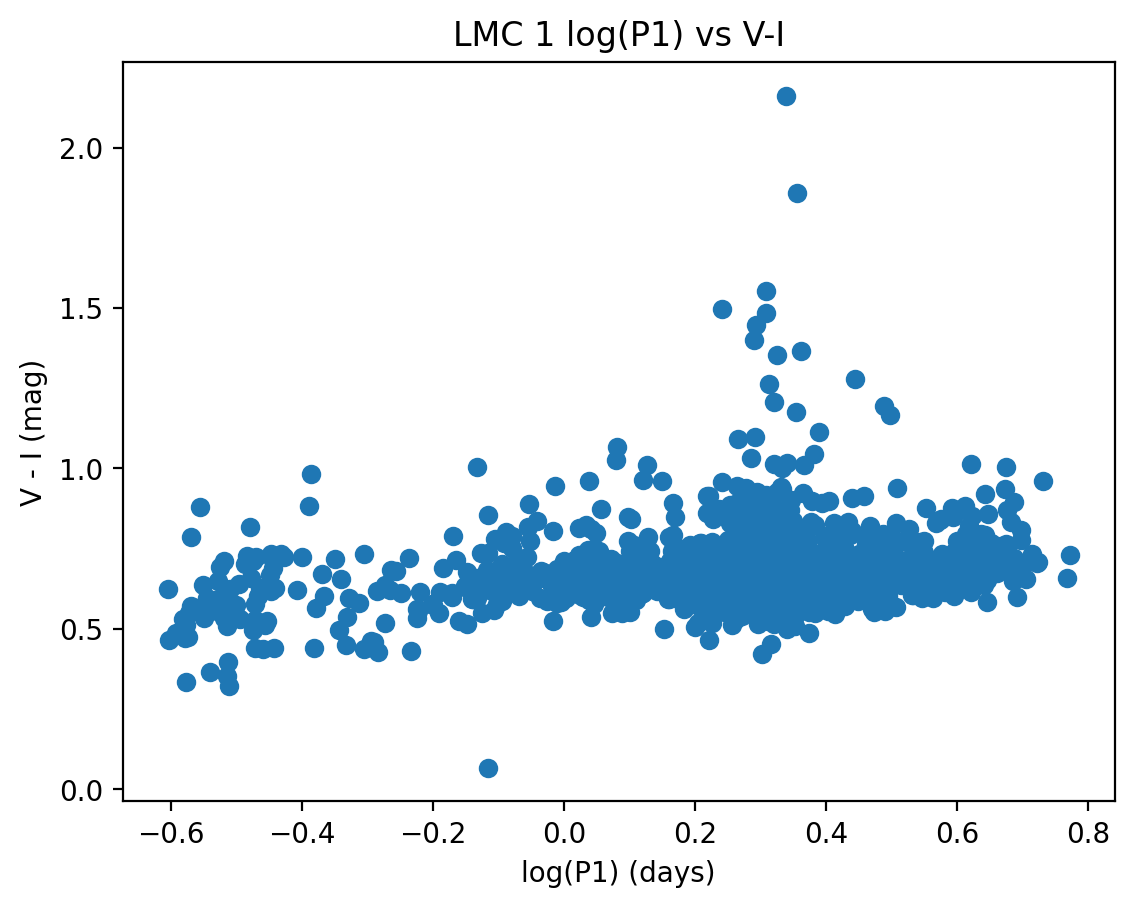

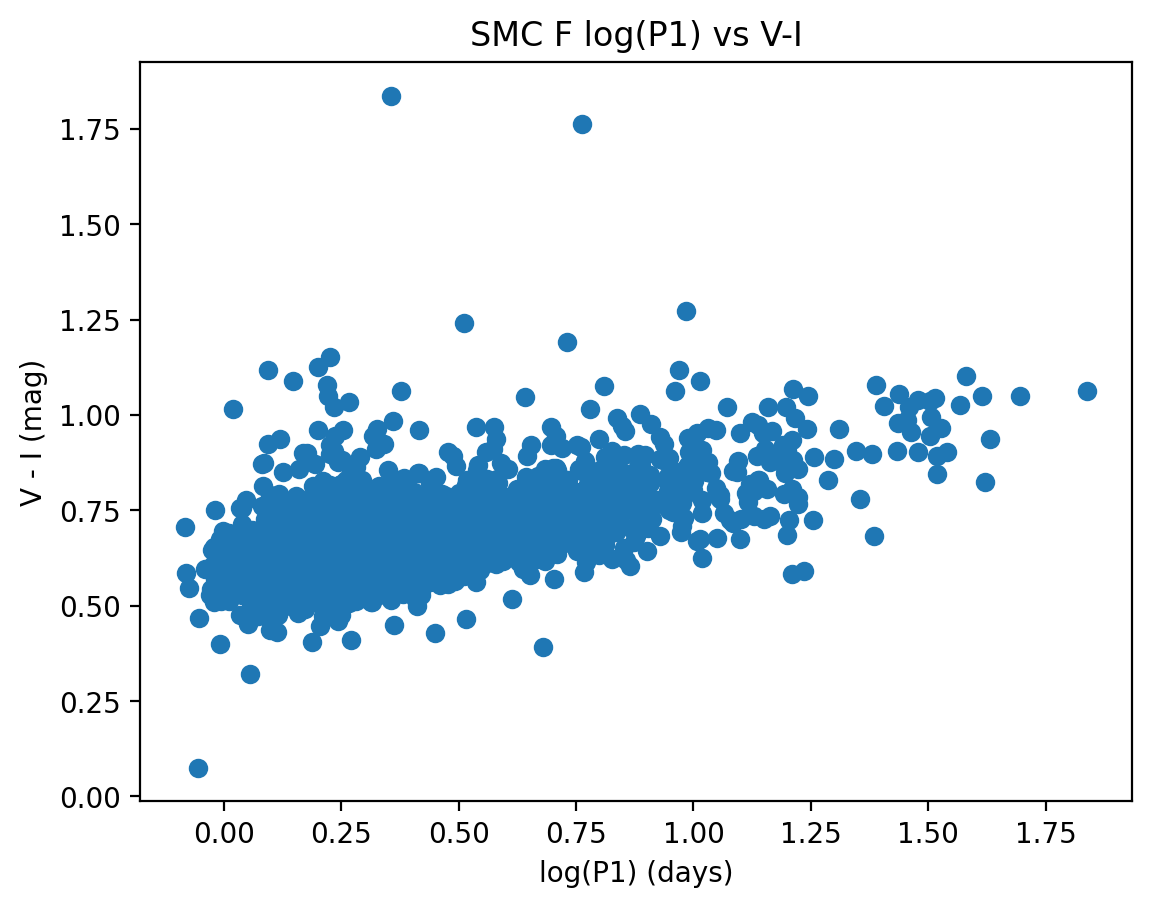

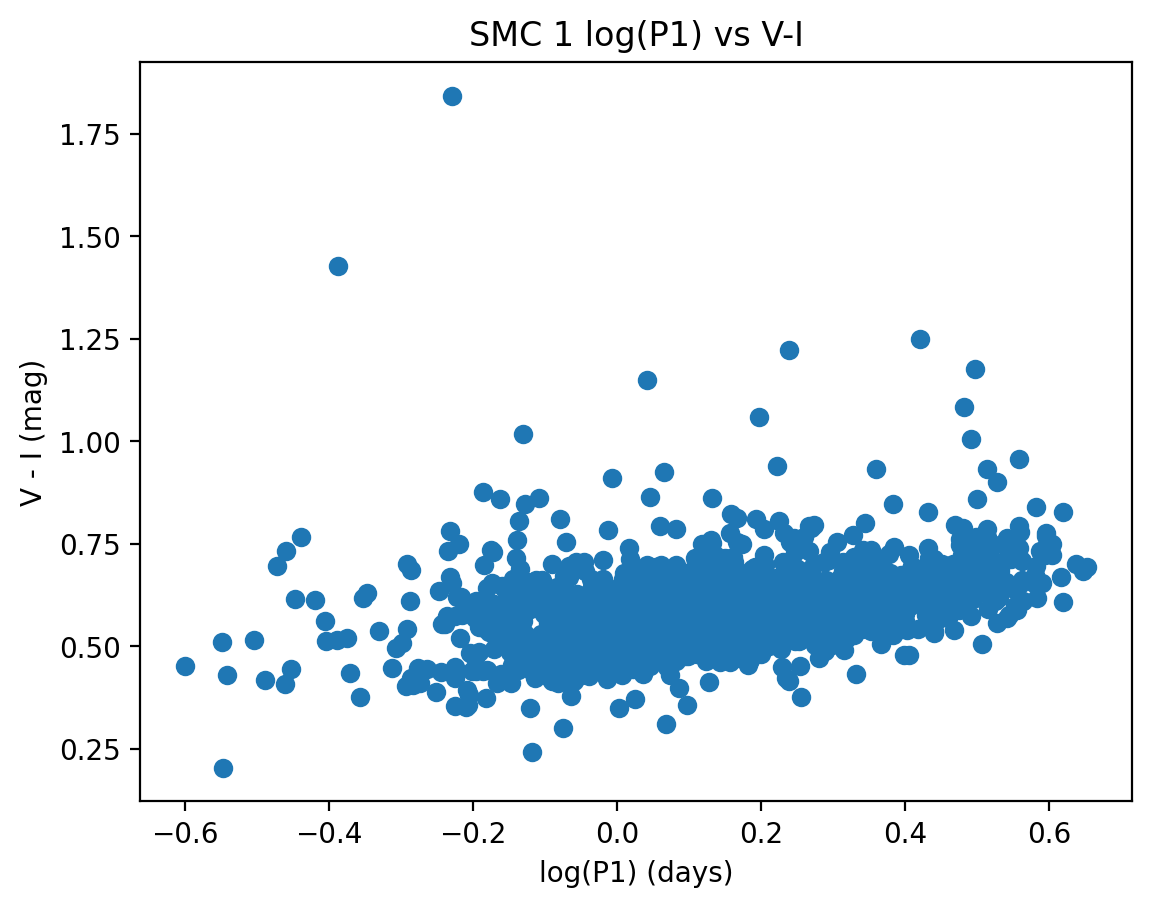

In [109]:
for i, dataset in enumerate(datasets):
    plt.scatter(dataset['logP1'], dataset['VI'])
    plt.xlabel("log(P1) (days)")
    plt.ylabel("V - I (mag)")
    plt.title(f'{dataset_labels[i]} log(P1) vs V-I')
    plt.show()

There appears to be a slight positive correlation between log(P1) and V-I for the Cepheids. There are also some apparent outliers present in all of the datasets. 